##### Installs

In [ ]:
!pip install tensorflow --quiet
!pip install tf_keras --quiet
!pip install transformers --quiet

### Imports

In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import BertTokenizer, TFBertModel, AutoTokenizer, TFAutoModel

from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Mounted at /content/drive


### Gloabal Parameters

In [2]:
FILE_PATH = '/content/drive/MyDrive/DS 266/data/'


TRAIN_DATA_SIZE = 10000
TEST_DATA_SIZE = 5000
MAX_SEQUENCE_LENGTH = 256

HIDDEN_SIZE = 100
DROPOUT = 0.3
LEARNING_RATE = 0.00005

VALIDATION_SPLIT = 0.2
BATCH_SIZE = 16
NUM_EPOCHS = 2

# Replace with your HuggingFace token
with open('/content/drive/MyDrive/DS 266/token_data/hf_Token.txt', 'r') as f:
    AUTH_TOKEN = f.read()

### Functions

In [3]:
def train_test_split_helper(data, test_size, random_state):
  """
  Seperate Data into train and test split
  """
  # Set random seed
  np.random.seed(random_state)

  # Shuffle the data and find test set size
  shuffled_indices = np.random.permutation(len(data))
  test_set_size = int(len(data) * test_size)

  # Split the indices into train and test
  test_indices = shuffled_indices[:test_set_size]
  train_indices = shuffled_indices[test_set_size:]

  # Use the indices to split the data
  train_data = data.iloc[train_indices]
  test_data = data.iloc[test_indices]

  return train_data, test_data

def tokenize_inputs(tokenizer, examples):
    """
    Tokenize the input text for the each of the BERT model variations to use.
    """
    tokenized_inputs = tokenizer(
        examples,
        max_length=MAX_SEQUENCE_LENGTH,
        truncation=True,
        padding='max_length',
        return_tensors='tf'
    )
    return {
        "input_ids": tokenized_inputs.input_ids,
        "token_type_ids": tokenized_inputs.token_type_ids,
        "attention_mask": tokenized_inputs.attention_mask
    }

def create_cls_model(
        bert_model,
        bert_trainable,
        max_sequence_length=MAX_SEQUENCE_LENGTH,
        hidden_size=HIDDEN_SIZE,
        dropout=DROPOUT,
        learning_rate=LEARNING_RATE
    ):
    """
    Build a simple classification model using a BERT encoder model. Use the CLS Token output for classification purposes.
    """

    bert_model.trainable = bert_trainable

    input_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int32, name='input_ids')
    token_type_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int32, name='token_type_ids')
    attention_mask = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int32, name='attention_mask')

    bert_inputs = {
        'input_ids': input_ids,
        'token_type_ids': token_type_ids,
        'attention_mask': attention_mask
    }

    bert_output = bert_model(bert_inputs)

    cls_token = bert_output[0][:, 0, :]
    hidden_layer = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(cls_token)
    dropout_layer = tf.keras.layers.Dropout(dropout)(hidden_layer)
    classification_layer = tf.keras.layers.Dense(1, activation='sigmoid', name='classification_layer')(dropout_layer)

    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification_layer])
    classification_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return classification_model

def convert_toDT(timestamp):
  """
  Convert Unix Timestamp to date
  """

  date = datetime.fromtimestamp(float(timestamp))
  formatted_date = date.strftime("%Y/%m/%d")
  return formatted_date

#### Data

In [4]:
subreddit_list = {
    'conspiracy': 0,
    'divorce': 0,
    'fitness': 0,
    'guns': 0,
    'jokes': 0,
    'legaladvice': 0,
    'meditation': 0,
    'parenting': 0,
    'personalfinance': 0,
    'relationships': 0,
    'teaching': 0,
    'mentalhealth': 1,
    'addiction': 1,
    'alcoholism': 1,
    'adhd': 1,
    'anxiety': 1,
    'autism': 1,
    'bipolarreddit': 1,
    'bpd': 1,
    'depression': 1,
    'healthanxiety': 1,
    'lonely': 1,
    'ptsd': 1,
    'schizophrenia': 1,
    'socialanxiety': 1,
    'suicidewatch': 1
}

# Define a function to read and process a single CSV
def read_and_label_csv(subreddit, time_period):
    df = pd.read_csv(f'{FILE_PATH}{subreddit}_{time_period}_features_tfidf_256.csv')
    df = df[['subreddit', 'author', 'date', 'post']]
    df = df[df['subreddit'].isin(subreddit_list.keys())]
    df['suicide_risk'] = df['subreddit'].apply(lambda x: 1 if x == 'suicidewatch' else 0)
    df['mental_health'] = df['subreddit'].apply(lambda x: 1 if x in [k for k, v in subreddit_list.items() if v == 1] else 0)
    return df

# Identify unique authors that posted in r/suicidewatch
suicidal_authors = set(pd.concat([read_and_label_csv('suicidewatch', time_period) for time_period in ['2018', '2019', 'pre', 'post']])['author'])

# Generate training and test data with labels
train_data = pd.concat([read_and_label_csv(subreddit, 'pre') for subreddit in subreddit_list])
test_data = pd.concat([read_and_label_csv(subreddit, 'post') for subreddit in subreddit_list])

# Take a subset of the data ensuring balance between positive and negative labels
train_data_positive = train_data[train_data['suicide_risk'] == 1].sample(n=TRAIN_DATA_SIZE//2, random_state=42)
train_data_negative = train_data[train_data['suicide_risk'] == 0].sample(n=TRAIN_DATA_SIZE//2, random_state=42)
train_data = pd.concat([train_data_positive, train_data_negative]).sample(frac=1, random_state=42)
train_data['date'] = pd.to_datetime(train_data['date']).dt.strftime('%Y-%m')

test_data_positive = test_data[test_data['suicide_risk'] == 1].sample(n=TEST_DATA_SIZE//2, random_state=42)
test_data_negative = test_data[test_data['suicide_risk'] == 0].sample(n=TEST_DATA_SIZE//2, random_state=42)
test_data = pd.concat([test_data_positive, test_data_negative]).sample(frac=1, random_state=42)
test_data['date'] = pd.to_datetime(test_data['date']).dt.strftime('%Y-%m')
test_data['suicidal_author'] = test_data['author'].apply(lambda x: 1 if x in suicidal_authors else 0)

# Collect examples and labels for tokenization and modeling
train_examples = train_data['post'].to_list()
train_labels = train_data['suicide_risk'].to_numpy()
test_examples = test_data['post'].to_list()
test_labels = test_data['suicide_risk'].to_numpy()

### Tokenizers

In [5]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
bert_train_inputs = tokenize_inputs(bert_tokenizer, train_examples)
bert_test_inputs = tokenize_inputs(bert_tokenizer, test_examples)

mentalbert_tokenizer = AutoTokenizer.from_pretrained('mental/mental-bert-base-uncased', use_auth_token=AUTH_TOKEN)
mentalbert_train_inputs = tokenize_inputs(mentalbert_tokenizer, train_examples)
mentalbert_test_inputs = tokenize_inputs(mentalbert_tokenizer, test_examples)

disorbert_tokenizer = AutoTokenizer.from_pretrained('citiusLTL/DisorBERT')
disorbert_train_inputs = tokenize_inputs(disorbert_tokenizer, train_examples)
disorbert_test_inputs = tokenize_inputs(disorbert_tokenizer, test_examples)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/auto/tokenization_auto.py:809: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/321 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

### Baseline Models

##### BERT

In [11]:
bert_baseline = create_cls_model(
    TFBertModel.from_pretrained('bert-base-cased'),
    bert_trainable=False,
    max_sequence_length=MAX_SEQUENCE_LENGTH,
    hidden_size=HIDDEN_SIZE,
    dropout=DROPOUT,
    learning_rate=LEARNING_RATE
)
bert_baseline.fit(
    bert_train_inputs,
    train_labels,
    validation_split=VALIDATION_SPLIT,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS
)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/2
67/67 [==============================] - 23s 109ms/step - loss: 0.7460 - accuracy: 0.4891 - val_loss: 0.7084 - val_accuracy: 0.4491
Epoch 2/2
67/67 [==============================] - 4s 61ms/step - loss: 0.7183 - accuracy: 0.5175 - val_loss: 0.7024 - val_accuracy: 0.4755


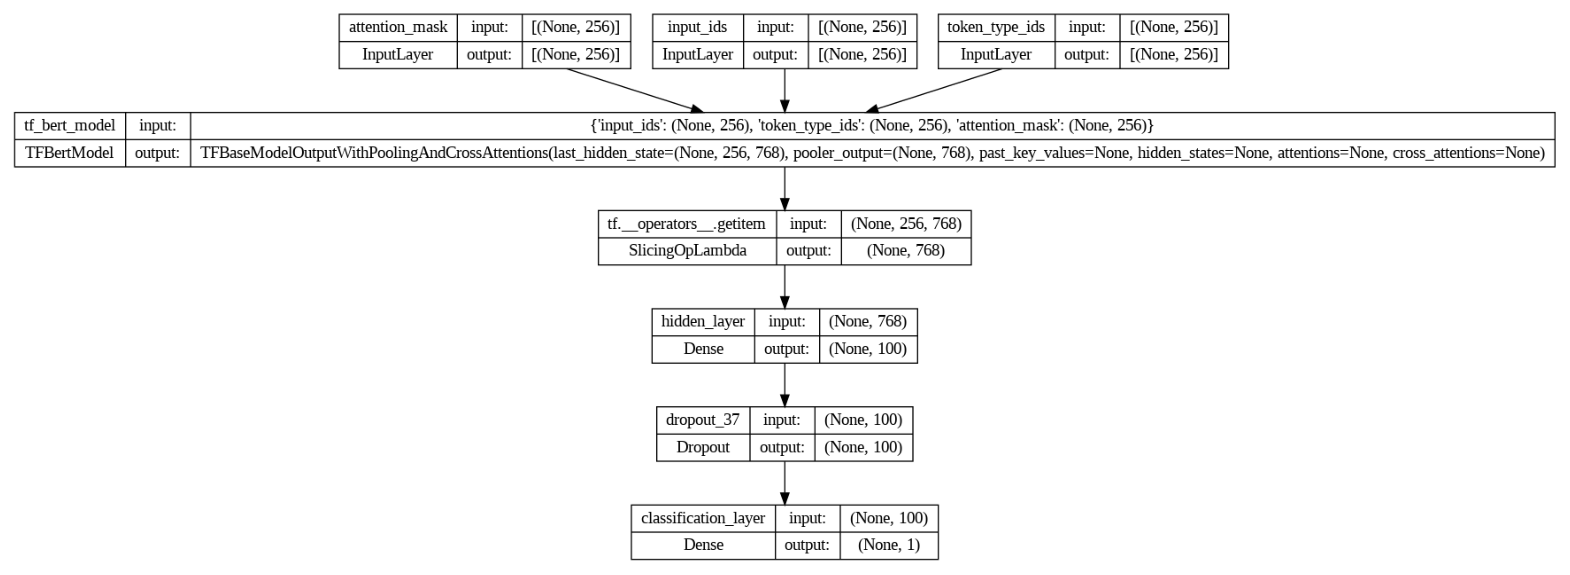

In [12]:
tf.keras.utils.plot_model(bert_baseline, show_shapes=True, to_file='bert_baseline_diagram.png')

plt.figure(figsize=(20, 10))
plt.imshow(plt.imread('bert_baseline_diagram.png'))
plt.axis('off')
plt.show()

##### MentalBERT

In [13]:
mentalbert_baseline = create_cls_model(
    TFAutoModel.from_pretrained('mental/mental-bert-base-uncased', use_auth_token=AUTH_TOKEN, from_pt=True),
    bert_trainable=False,
    max_sequence_length=MAX_SEQUENCE_LENGTH,
    hidden_size=HIDDEN_SIZE,
    dropout=DROPOUT,
    learning_rate=LEARNING_RATE
)
mentalbert_baseline.fit(
    mentalbert_train_inputs,
    train_labels,
    validation_split=VALIDATION_SPLIT,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS
)

/usr/local/lib/python3.10/dist-packages/transformers/models/auto/auto_factory.py:471: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


config.json:   0%|          | 0.00/639 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'bert.embeddings.position_ids', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertModel were not initialized from the PyTorch model and are newly initialized: ['bert.pooler.dense.weight', 'bert.p

Epoch 1/2
67/67 [==============================] - 19s 107ms/step - loss: 0.6866 - accuracy: 0.5798 - val_loss: 0.6515 - val_accuracy: 0.6151
Epoch 2/2
67/67 [==============================] - 4s 60ms/step - loss: 0.6638 - accuracy: 0.5940 - val_loss: 0.6322 - val_accuracy: 0.6679


##### DisorBERT

In [14]:
disorbert_baseline = create_cls_model(
    TFAutoModel.from_pretrained('citiusLTL/DisorBERT', from_pt=True),
    bert_trainable=False,
    max_sequence_length=MAX_SEQUENCE_LENGTH,
    hidden_size=HIDDEN_SIZE,
    dropout=DROPOUT,
    learning_rate=LEARNING_RATE
)
disorbert_baseline.fit(
    disorbert_train_inputs,
    train_labels,
    validation_split=VALIDATION_SPLIT,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS
)

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'bert.embeddings.position_ids', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertModel were not initialized from the PyTorch model and are newly initialized: ['bert.pooler.dense.weight', 'bert.p

Epoch 1/2
67/67 [==============================] - 19s 105ms/step - loss: 0.7399 - accuracy: 0.4684 - val_loss: 0.6957 - val_accuracy: 0.4679
Epoch 2/2
67/67 [==============================] - 4s 59ms/step - loss: 0.7087 - accuracy: 0.5175 - val_loss: 0.6824 - val_accuracy: 0.5396


### Fine-Tuned Models

##### BERT

In [15]:
bert_finetuned = create_cls_model(
    TFBertModel.from_pretrained('bert-base-cased'),
    bert_trainable=True,
    max_sequence_length=MAX_SEQUENCE_LENGTH,
    hidden_size=HIDDEN_SIZE,
    dropout=DROPOUT,
    learning_rate=LEARNING_RATE
)
bert_finetuned.fit(
    bert_train_inputs,
    train_labels,
    validation_split=VALIDATION_SPLIT,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/2


67/67 [==============================] - 49s 202ms/step - loss: 0.6509 - accuracy: 0.6242 - val_loss: 0.5206 - val_accuracy: 0.7698
Epoch 2/2
67/67 [==============================] - 10s 148ms/step - loss: 0.5127 - accuracy: 0.7620 - val_loss: 0.4846 - val_accuracy: 0.7698


##### MentalBERT

In [16]:
mentalbert_finetuned = create_cls_model(
    TFAutoModel.from_pretrained('mental/mental-bert-base-uncased', use_auth_token=AUTH_TOKEN, from_pt=True),
    bert_trainable=True,
    max_sequence_length=MAX_SEQUENCE_LENGTH,
    hidden_size=HIDDEN_SIZE,
    dropout=DROPOUT,
    learning_rate=LEARNING_RATE
)
mentalbert_finetuned.fit(
    mentalbert_train_inputs,
    train_labels,
    validation_split=VALIDATION_SPLIT,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'bert.embeddings.position_ids', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertModel were not initialized from the PyTorch model and are newly initialized: ['bert.pooler.dense.weight', 'bert.p

Epoch 1/2


67/67 [==============================] - 49s 204ms/step - loss: 0.6565 - accuracy: 0.6157 - val_loss: 0.5918 - val_accuracy: 0.7132
Epoch 2/2
67/67 [==============================] - 10s 144ms/step - loss: 0.4947 - accuracy: 0.7809 - val_loss: 0.4929 - val_accuracy: 0.7736


##### DisorBERT

In [17]:
disorbert_finetuned = create_cls_model(
    TFAutoModel.from_pretrained('citiusLTL/DisorBERT', from_pt=True),
    bert_trainable=True,
    max_sequence_length=MAX_SEQUENCE_LENGTH,
    hidden_size=HIDDEN_SIZE,
    dropout=DROPOUT,
    learning_rate=LEARNING_RATE
)
disorbert_finetuned.fit(
    disorbert_train_inputs,
    train_labels,
    validation_split=VALIDATION_SPLIT,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'bert.embeddings.position_ids', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertModel were not initialized from the PyTorch model and are newly initialized: ['bert.pooler.dense.weight', 'bert.p

Epoch 1/2


67/67 [==============================] - 49s 207ms/step - loss: 0.6583 - accuracy: 0.6147 - val_loss: 0.5475 - val_accuracy: 0.7396
Epoch 2/2
67/67 [==============================] - 10s 144ms/step - loss: 0.4852 - accuracy: 0.7696 - val_loss: 0.4770 - val_accuracy: 0.7887


### Further Fine-Tuning

In [22]:
train_data0 = pd.concat([read_and_label_csv(subreddit, '2018') for subreddit in subreddit_list])
train_data1 = pd.concat([read_and_label_csv(subreddit, '2019') for subreddit in subreddit_list])

train_data = pd.concat([train_data0, train_data1])

# Take a subset of the data ensuring balance between positive and negative labels
train_data_positive = train_data[train_data['suicide_risk'] == 1].sample(n=TRAIN_DATA_SIZE//2, random_state=42)
train_data_negative = train_data[train_data['suicide_risk'] == 0].sample(n=TRAIN_DATA_SIZE//2, random_state=42)
train_data = pd.concat([train_data_positive, train_data_negative]).sample(frac=1, random_state=42)
train_data['date'] = pd.to_datetime(train_data['date']).dt.strftime('%Y-%m')

train_data = train_data[(train_data['subreddit'] == 'suicidewatch') | (train_data['subreddit'] == 'depression')]

In [23]:
# Define the target size for each class (50/50 split)
target_size = min(
    len(train_data[train_data['subreddit'] == 'suicidewatch']),
    len(train_data[train_data['subreddit'] == 'depression'])
)

# Sample equal numbers of rows from each subreddit
suicidewatch_data = train_data[train_data['subreddit'] == 'suicidewatch'].sample(n=target_size, random_state=42)
depression_data = train_data[train_data['subreddit'] == 'depression'].sample(n=target_size, random_state=42)

# Combine and shuffle the balanced data
balanced_train_data = pd.concat([suicidewatch_data, depression_data]).sample(frac=1, random_state=42).reset_index(drop=True)

train_examples = balanced_train_data['post'].to_list()
train_labels = balanced_train_data['suicide_risk'].to_numpy()

##### Tokenizers

In [24]:
bert_train_inputs = tokenize_inputs(bert_tokenizer, train_examples)
mentalbert_train_inputs = tokenize_inputs(mentalbert_tokenizer, train_examples)
disorbert_train_inputs = tokenize_inputs(disorbert_tokenizer, train_examples)

##### BERT

In [25]:
bert_finetuned.fit(
    bert_train_inputs,
    train_labels,
    validation_split=VALIDATION_SPLIT,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS
)

Epoch 1/2
67/67 [==============================] - 10s 142ms/step - loss: 0.2910 - accuracy: 0.8876 - val_loss: 0.6714 - val_accuracy: 0.7358
Epoch 2/2
67/67 [==============================] - 9s 141ms/step - loss: 0.1544 - accuracy: 0.9452 - val_loss: 0.7251 - val_accuracy: 0.7660


##### MentalBERT

In [26]:
mentalbert_finetuned.fit(
    mentalbert_train_inputs,
    train_labels,
    validation_split=VALIDATION_SPLIT,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS
)

Epoch 1/2
67/67 [==============================] - 10s 143ms/step - loss: 0.2730 - accuracy: 0.8999 - val_loss: 0.5802 - val_accuracy: 0.7925
Epoch 2/2
67/67 [==============================] - 9s 140ms/step - loss: 0.1215 - accuracy: 0.9603 - val_loss: 0.8276 - val_accuracy: 0.7962


##### DisorBERT

In [27]:
disorbert_finetuned.fit(
    disorbert_train_inputs,
    train_labels,
    validation_split=VALIDATION_SPLIT,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS
)

Epoch 1/2
67/67 [==============================] - 9s 141ms/step - loss: 0.2838 - accuracy: 0.8961 - val_loss: 0.6275 - val_accuracy: 0.7132
Epoch 2/2
67/67 [==============================] - 9s 134ms/step - loss: 0.1254 - accuracy: 0.9547 - val_loss: 0.8236 - val_accuracy: 0.7925


#### Predictions & Evaluations

In [28]:
metrics = [compute_metrics(model, test_prediction, test_labels) for model, test_prediction in test_predictions.items()]
pd.DataFrame(metrics)

,model,accuracy,precision,recall,f1_score
0,bert_baseline,0.5714,0.550098,0.7840,0.646545
1,mentalbert_baseline,0.6330,0.605522,0.7632,0.675279
2,disorbert_baseline,0.5496,0.628099,0.2432,0.350634
3,bert_finetuned,0.8026,0.869565,0.7120,0.782934
4,mentalbert_finetuned,0.7886,0.906937,0.6432,0.752633
5,disorbert_finetuned,0.7894,0.832338,0.7248,0.774856


<ipython-input-19-b30467fe165f>:42: UserWarning: The figure layout has changed to tight
  plt.tight_layout()  # Adjust layout to prevent labels from overlapping


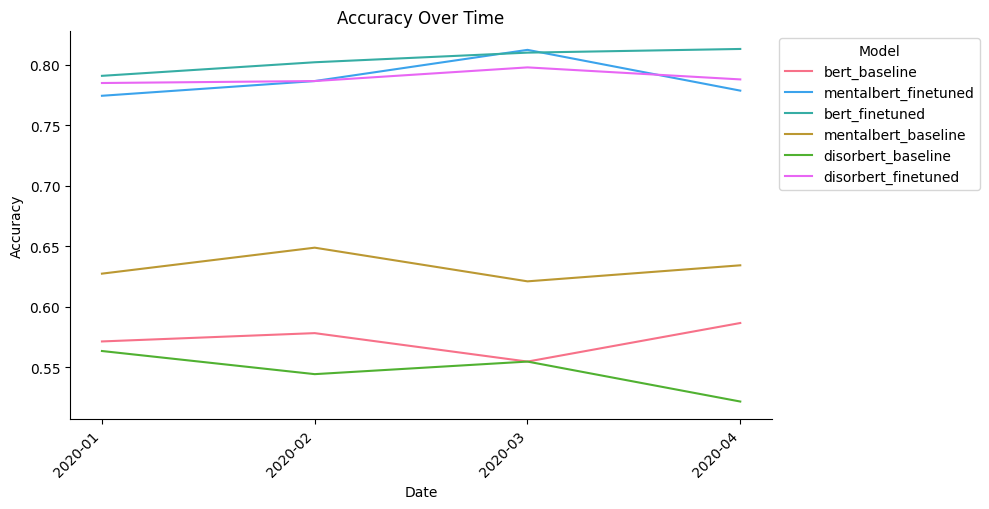

<ipython-input-19-b30467fe165f>:42: UserWarning: The figure layout has changed to tight
  plt.tight_layout()  # Adjust layout to prevent labels from overlapping


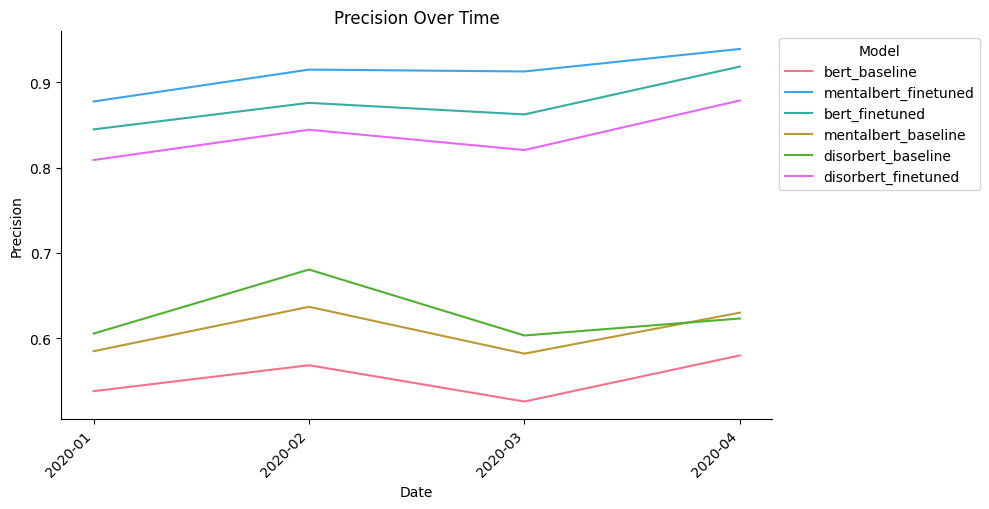

<ipython-input-19-b30467fe165f>:42: UserWarning: The figure layout has changed to tight
  plt.tight_layout()  # Adjust layout to prevent labels from overlapping


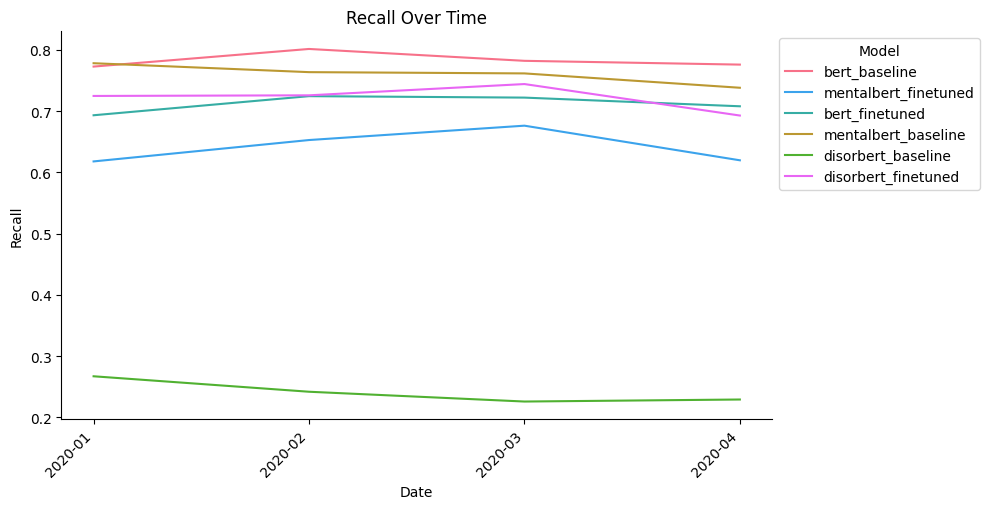

<ipython-input-19-b30467fe165f>:42: UserWarning: The figure layout has changed to tight
  plt.tight_layout()  # Adjust layout to prevent labels from overlapping


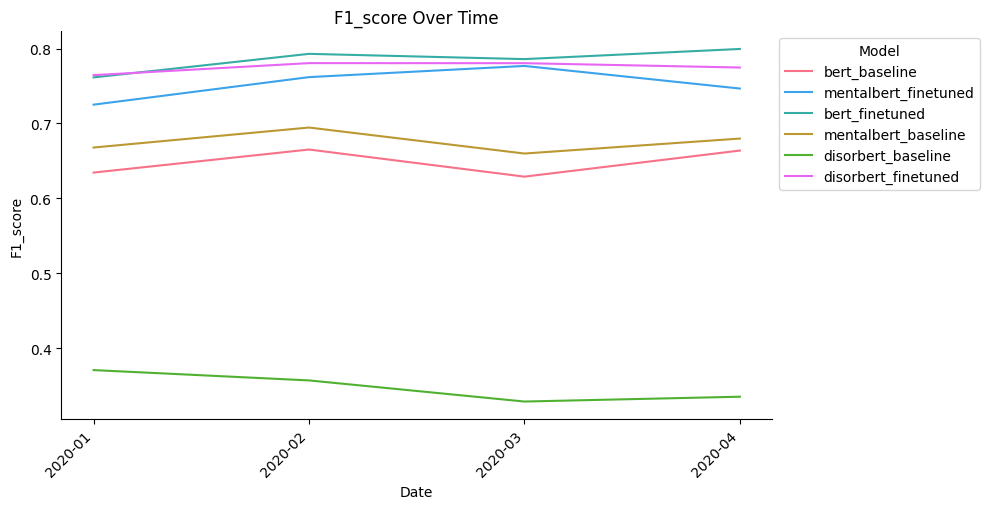

In [29]:
# Do the metrics get worse over time throughout the onset of COVID-19?

results = []
for model_name in test_predictions.keys():
    for date, group in evaluation_df.groupby('date'):
        y_true = group['suicide_risk'].values
        y_pred = group[model_name].values

        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, zero_division=0) # Handle potential zero division
        recall = recall_score(y_true, y_pred, zero_division=0) # Handle potential zero division
        f1 = f1_score(y_true, y_pred, zero_division=0) # Handle potential zero division

        results.append({
            'model': model_name,
            'date': date,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        })

results_df = pd.DataFrame(results)

# Plot each metric
metrics = ['accuracy', 'precision', 'recall', 'f1_score']
for metric in metrics:
    plot_metric_over_time(metric, results_df)

<ipython-input-20-74f47130ff20>:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  false_positive_rates = grouped_df.apply(lambda x: sum((x[model_name] == 1) & (x['suicide_risk'] == 0)) / len(x))
<ipython-input-20-74f47130ff20>:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  false_positive_rates = grouped_df.apply(lambda x: sum((x[model_name] == 1) & (x['suicide_risk'] == 0)) / len(x))
<ipython-input-20-74

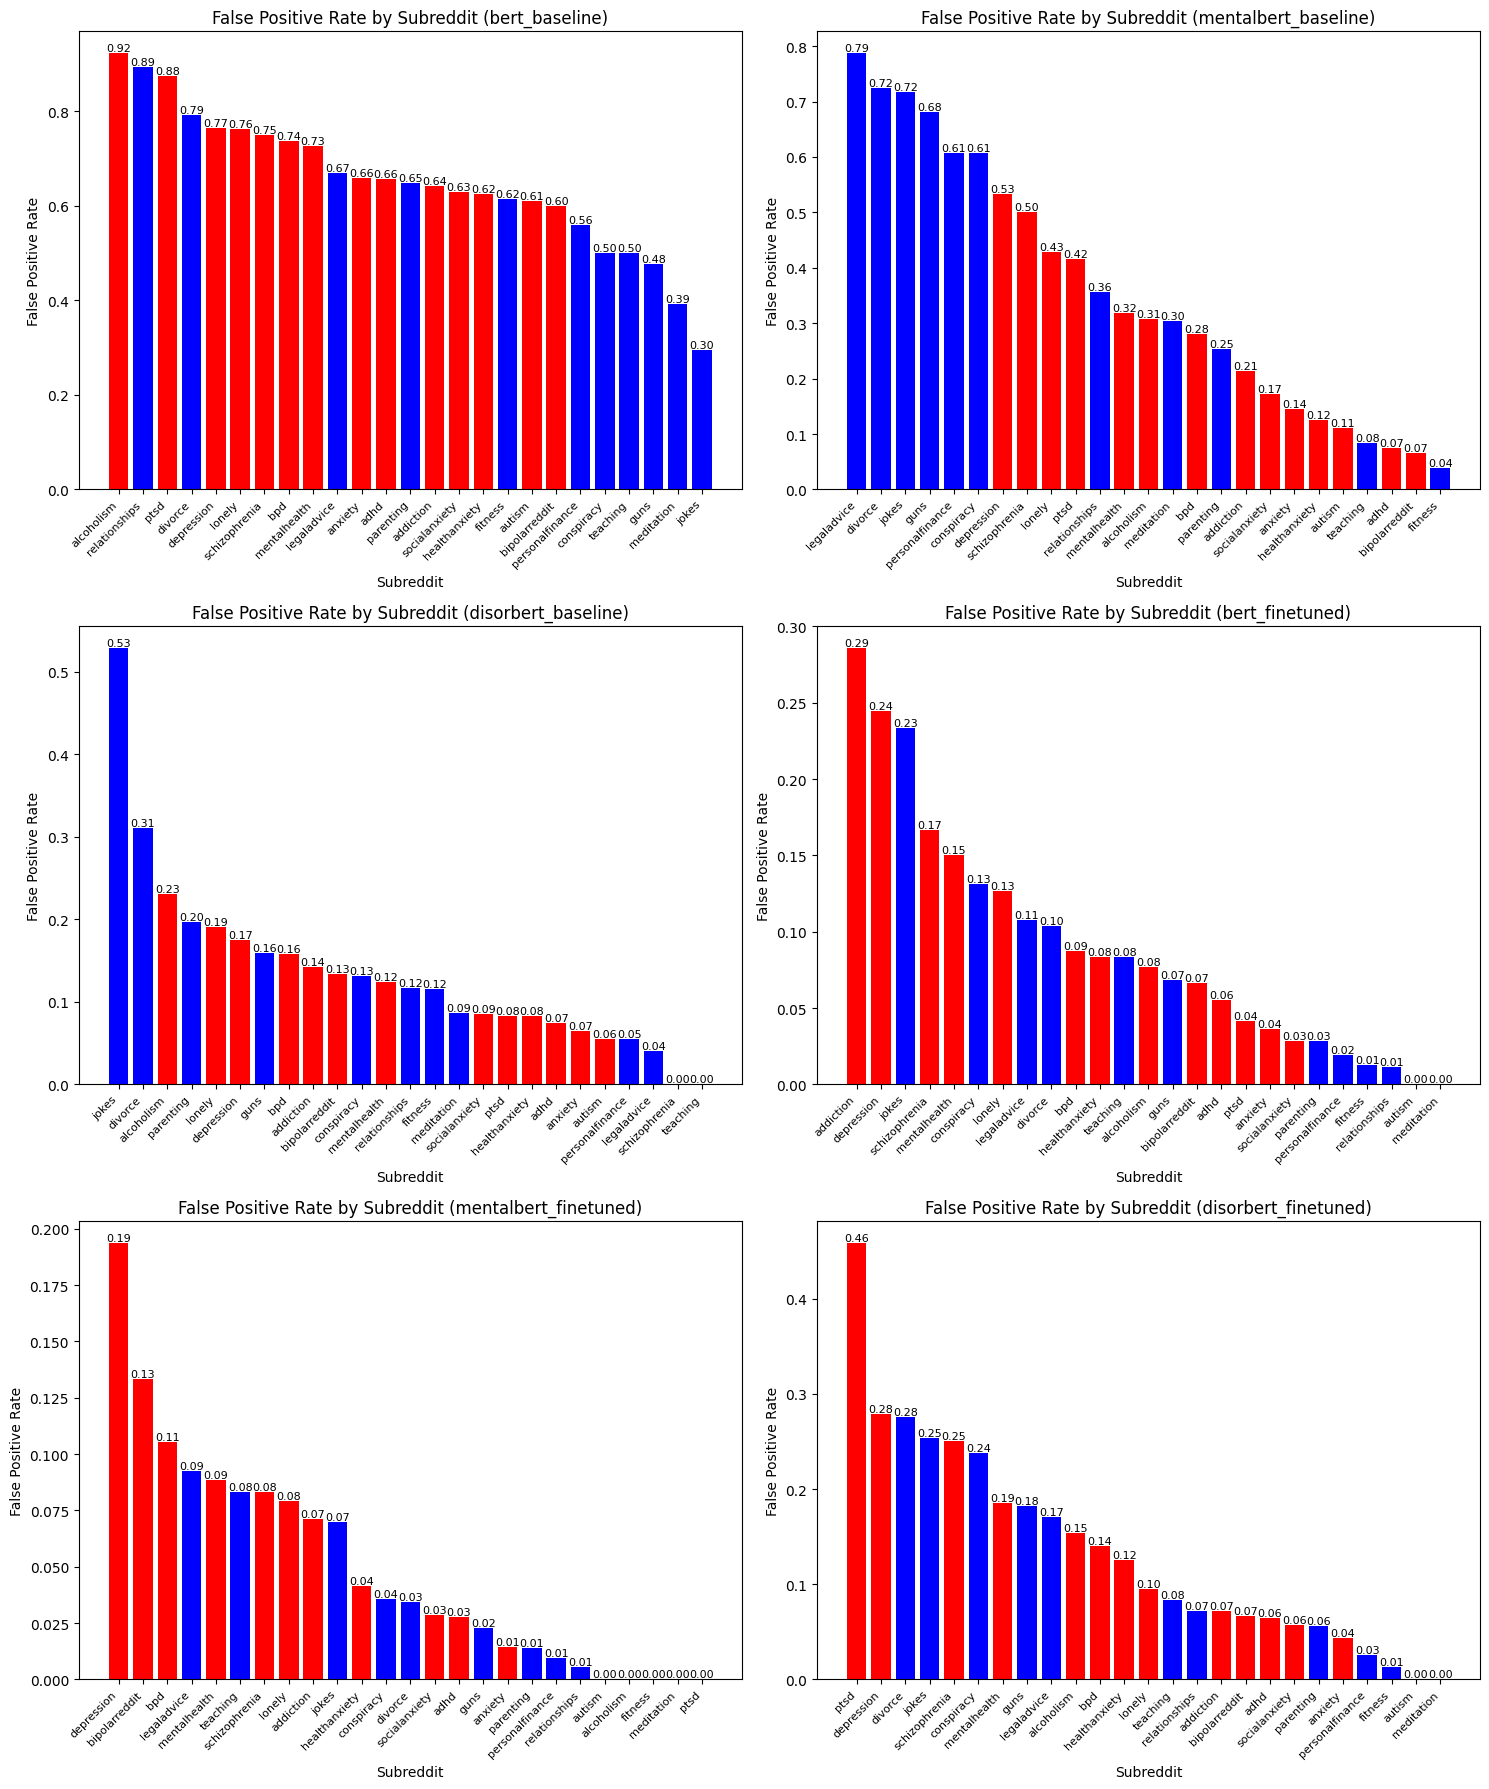

In [30]:
# Do false positives become more frequent for mental health vs non-mental health subreddits?
models_to_plot = list(test_predictions.keys())
plot_false_positive_rates(evaluation_df, models_to_plot)

In [31]:
# Do false positives become more frequent for authors who also posted in r/suicidewatch?

filtered_df = evaluation_df[evaluation_df['suicide_risk'] == 0]
results = []

for model in test_predictions.keys():
    fp_suicidal_author = len(filtered_df[(filtered_df['suicidal_author'] == 1) & (filtered_df[model] == 1)]) / len(filtered_df[filtered_df['suicidal_author'] == 1]) if len(filtered_df[filtered_df['suicidal_author'] == 1]) > 0 else 0
    fp_non_suicidal_author = len(filtered_df[(filtered_df['suicidal_author'] == 0) & (filtered_df[model] == 1)]) / len(filtered_df[filtered_df['suicidal_author'] == 0]) if len(filtered_df[filtered_df['suicidal_author'] == 0]) > 0 else 0

    results.append({
        'model': model,
        'false_positive_suicidal_author': fp_suicidal_author,
        'false_positive_non_suicidal_author': fp_non_suicidal_author
    })

pd.DataFrame(results)

,model,false_positive_suicidal_author,false_positive_non_suicidal_author
0,bert_baseline,0.705128,0.639141
1,mentalbert_baseline,0.487179,0.497523
2,disorbert_baseline,0.141026,0.144096
3,bert_finetuned,0.282051,0.101156
4,mentalbert_finetuned,0.294872,0.058629
5,disorbert_finetuned,0.294872,0.141206


###### DS.266